In [24]:
import os
import glob
import sys

import common as com
import numpy
import tqdm
import sklearn
import torch
from train import list_to_vector_array
from train import file_list_generator
from train import AutoEncoder
from train import fetch_dataloaders
import torch.nn as nn


In [95]:
########################################################################
# visualizer
########################################################################
class Visualizer(object):
    def __init__(self):
        import matplotlib.pyplot as plt
        self.plt = plt
        self.fig = self.plt.figure(figsize=(30, 10))
        self.plt.subplots_adjust(wspace=0.3, hspace=0.3)

    def loss_plot(self, loss):
        """
        Plot loss curve.
        loss : list [ float ]
            training loss time series.
        val_loss : list [ float ]
            validation loss time series.
        return   : None
        """
        ax = self.fig.add_subplot(1, 1, 1)
        ax.cla()
        ax.plot(loss)
        #设置y轴范围
        #self.plt.ylim(-5,100)
        ax.set_title("batch loss")
        ax.set_xlabel("batch")
        ax.set_ylabel("Loss")
        ax.legend(["Train", "Validation"], loc="upper right")

    def save_figure(self, name):
        """
        Save figure.
        name : str
            save png file path.
        return : None
        """
        self.plt.savefig(name)
visualizer = Visualizer()

In [57]:
param = com.yaml_load()
def test(dir):
    ab_dir = '../file/noise_detect'
    ab_files = file_list_generator(ab_dir, dir_name=dir)
    com.logger.info('files num {num}'.format(num=len(ab_files)))
    ab_data = list_to_vector_array(ab_files,
                                   msg="generate train_dataset",
                                   n_mels=param["feature"]["n_mels"],
                                   frames=param["feature"]["frames"],
                                   n_fft=param["feature"]["n_fft"],
                                   hop_length=param["feature"]["hop_length"],
                                   power=param["feature"]["power"])
    ab_data = torch.Tensor(ab_data)
    com.logger.info('data num {num}'.format(num=len(ab_data)))
    ab_loader = torch.utils.data.DataLoader(
        dataset=ab_data, batch_size=512, shuffle=True)
    model = torch.load('model/model.pkl')
    loss_func = nn.MSELoss()
    features = []
    loss_his = []
    for data in ab_loader:
        inputs = data
        feature, y = model(inputs)
        loss = loss_func(y, inputs)
        loss_his.append(loss)
        for one_feature in feature:
            features.append(one_feature)
        
    return loss_his,features

ab_loss,ab_feature = test('test/abnormal')
normal_loss,normal_feature = test('test/normal')


2021-10-13 20:09:45,612 - INFO - target_dir : ../file/noise_detect
2021-10-13 20:09:45,614 - INFO - train_file num : 4
2021-10-13 20:09:45,615 - INFO - files num 4
generate train_dataset: 100%|██████████| 4/4 [00:00<00:00, 54.13it/s]
2021-10-13 20:09:45,692 - INFO - data num 2488
2021-10-13 20:09:45,810 - INFO - target_dir : ../file/noise_detect
2021-10-13 20:09:45,812 - INFO - train_file num : 44
2021-10-13 20:09:45,813 - INFO - files num 44
generate train_dataset: 100%|██████████| 44/44 [00:00<00:00, 65.62it/s]
2021-10-13 20:09:46,503 - INFO - data num 27368
C:\ZTTTX\Programing\Anaconda\envs\noise_detect\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


In [96]:
print(len(normal_loss))

visualizer.loss_plot(ab_loss)
visualizer.save_figure('abloss_his.png')
visualizer.loss_plot(normal_loss)
visualizer.save_figure('normal_loss_his.png')


54


C:\ZTTTX\Programing\Anaconda\envs\noise_detect\lib\site-packages\ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


5

In [3]:
#ab_feature = numpy.load('feature/abdata.npy',allow_pickle = True)
#normal_feature = numpy.load('feature/short_normal_data.npy',allow_pickle = True)

#ab_feature = [item.detach().numpy() for item in ab_feature ]
#normal_feature = [item.detach().numpy() for item in normal_feature ]


In [58]:
print(len(ab_feature))
len(normal_feature)

2488


27368

In [59]:
from sklearn.manifold import TSNE
import torch
ab_feature = [item.detach().numpy() for item in ab_feature ]
normal_feature = [item.detach().numpy() for item in normal_feature ]
feature = ab_feature + normal_feature
tsne = TSNE(n_components=2, init='pca', random_state=0)
result = tsne.fit_transform(feature)
label = torch.cat([torch.zeros(len(ab_feature)),torch.ones(len(normal_feature))],dim=0)
print(label.shape)
print(len(feature))
print(len(label))
print(label)


torch.Size([29856])
29856
29856
tensor([0., 0., 0.,  ..., 1., 1., 1.])


In [78]:
feature

[array([ 0.26577276, -0.19334233,  0.11228485,  0.1255474 ,  0.12666753,
        -0.13766356, -0.06364302,  0.40717205, -0.10550852,  0.7262184 ,
         0.16608575, -0.33273   ,  0.4464846 ,  0.25369856,  0.05177032,
         0.09574799,  0.17794667, -0.70928156, -0.41837084,  0.28417173,
        -0.56402236, -0.1504418 ,  0.0902286 ,  0.11100023, -0.18667892,
         0.03346729,  0.10821944,  0.3828379 ,  0.13194579, -0.22961889,
        -0.27880704,  0.1221451 ], dtype=float32),
 array([ 0.2685359 ,  0.13923392, -0.62038904, -0.29159442,  0.02048065,
         0.09590968,  0.47838244,  0.18526687, -0.01660014,  0.13988608,
         0.19203003,  0.11696266, -0.79737604,  0.42153725, -0.3930935 ,
         0.5150703 , -0.26992458, -0.12134382, -0.06120379,  0.7190498 ,
        -0.714776  , -0.78315824,  0.08825088, -1.0361356 ,  0.02460445,
         0.1044854 , -0.5075564 , -0.07321243,  0.06844988,  0.68411654,
         1.0280805 ,  0.2423302 ], dtype=float32),
 array([ 2.54523158e-0

In [82]:
import numpy as np
import matplotlib.pyplot as plt

def plot_embedding(data, label):
    x_min, x_max = np.min(data, 0), np.max(data, 0)
    data = (data - x_min) / (x_max - x_min)
    colors = {0:'r',1:'b'}
    fig = plt.figure()
    ax = plt.subplot(111)
    for i in range(data.shape[0]):
        plt.text(data[i, 0], data[i, 1], 'o',
                 color=colors[int(label[i])],
                 
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([])
    plt.yticks([])
    return fig

<Figure size 432x288 with 0 Axes>

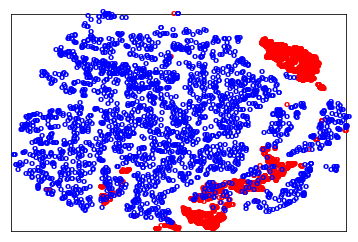

In [86]:

fig = plot_embedding(result[:5000],list(label[:5000]))
plt.savefig('feature_distribution')
plt.show(fig)
